In [152]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.optimize
from scipy import interpolate

import pandas as pd
import matplotlib.image as mpimg
import glob
import re
import pickle5 as pickle

from tqdm.notebook import tqdm

import numba
from numba.core import types
from numba.typed import Dict
import emcee

import sys
sys.path.append('../')
from functions import *

In [153]:
show_details = True
save_results = True

In [154]:
def curvature(x_path, y_path,scale):
    r, xcs, ycs = [],[],[]
    num_points = len(x_path)

    for i in range(int(scale),int(num_points-scale)):
        x1 = x_path[i-int(scale)]
        y1 = y_path[i-int(scale)]
        x2 = x_path[i]
        y2 = y_path[i]
        x3 = x_path[i+int(scale)]
        y3 = y_path[i+int(scale)]
        
        ma = (y2 - y1)/(x2 - x1)
        mb = (y3 - y2)/(x3 - x2)
        xc = (ma*mb*(y1 - y3) + mb*(x1 + x2) - ma*(x2 + x3))/(2*(mb - ma))
        yc = -1/ma*(xc - (x1 + x2)/2) + (y1 + y2)/2

        if ma == mb:
            rad = float(np.inf)
        else:
            rad = float(np.hypot(xc - x1, yc - y1))

        nv1 = np.cross(np.array([x2 - x1, y2 - y1, 0]), np.array([0 ,0, 1]))
        nv2 = np.cross(np.array([x3 - x2, y3 - y2, 0]), np.array([0 ,0, 1]))
        nv = np.average([nv1, nv2], axis = 0)
        align = -np.sign(np.dot(nv[0:2], np.array([x2 - xc, y2 - yc])))

        if rad == 0:
            r.append(np.nan)
        else:
            r.append(align * 1./rad)
            
        xcs.append(xc)
        ycs.append(yc)

    return r


In [155]:
float_array = types.float64[:]
float_val = types.float64

@numba.njit
def deflection_exact_FC(param, x_dat, y_dat, Mk_zero = False, FC_zero = False, n_div=100):
    Fx, Mk, Fy, theta0, Fext, xF, xC, FC = param
    
    if Mk_zero:
        Mk = 0
    if FC_zero:
        FC = 0
    
    s_dat_ls, L_contour = contour_fn(x_dat, y_dat)
    ds = L_contour/n_div
    n_steps = int(1.15*n_div)
    
    
    x_ls = np.zeros(n_steps, dtype=np.float64)
    y_ls = np.zeros(n_steps)
    M_ls = np.zeros(n_steps)
    theta_ls = np.zeros(n_steps)
    
    
    theta_ls[0] = theta0
    found_F = False
    yF = 0
    Fext_x = 0
    Fext_y = Fext
    thetaF = np.pi/2
    
    for i in range(n_steps-1):
 
        xF_sign = np.sign(xF) * np.sign(xF - x_ls[i])
        if xF_sign < 0 and found_F == False:
            found_F = True
            
            iF = i-1
            yF = interpolate_two_pt(xF, x_ls[iF], x_ls[iF+1], y_ls[iF], y_ls[iF+1])
            thetaF = np.pi/2 + np.arctan2(y_ls[iF+1]-y_ls[iF], x_ls[iF+1]-x_ls[iF])
            Fext_x = Fext * np.cos(thetaF)
            Fext_y = Fext * np.sin(thetaF)
            
            
        M = Mk + Fx*y_ls[i] - Fy*x_ls[i]
        if found_F:
            M += Fext_x*(y_ls[i]-yF) - Fext_y*(x_ls[i]-xF)
        if x_ls[i] >= xC:
            M -= FC*(xC-x_ls[i]) 
        
        
        theta_mid = theta_ls[i] - ds/2*M
        y_mid = y_ls[i] + ds/2*np.sin(theta_mid)
        x_mid = x_ls[i] + ds/2*np.cos(theta_mid)
        
        
        M_mid = Mk + Fx*y_mid - Fy*x_mid
        if found_F:
            M_mid += Fext_x*(y_mid-yF) - Fext_y*(x_mid-xF)
        if x_mid >= xC:
            M_mid -= FC*(xC-x_mid) 
            
            
        theta_ls[i+1] = theta_ls[i] - ds*M_mid
        x_ls[i+1] = x_ls[i] + ds*np.cos(theta_mid)
        y_ls[i+1] = y_ls[i] + ds*np.sin(theta_mid)
        M_ls[i+1] = M_mid 
    
    
    deflect_arrays = Dict.empty(
        key_type=types.unicode_type,
        value_type=float_array
    )
    
    deflect_numbers = Dict.empty(
        key_type=types.unicode_type,
        value_type=float_val
    )
    
    deflect_arrays['x_mod'] = x_ls.astype(np.float64)
    deflect_arrays['y_mod'] = y_ls.astype(np.float64)
    deflect_arrays['theta_mod'] = theta_ls.astype(np.float64)
    deflect_arrays['M_mod'] = M_ls.astype(np.float64)
    
    deflect_numbers['Fext_x'] = np.float64(Fext_x)
    deflect_numbers['Fext_y'] = np.float64(Fext_y)
    deflect_numbers['xF'] = np.float64(xF)
    deflect_numbers['yF'] = np.float64(yF)
    deflect_numbers['thetaF'] = np.float64(thetaF)
    
    return deflect_arrays, deflect_numbers

In [156]:
@numba.njit
def find_loops(x_mod, y_mod):
    ds = np.sqrt((x_mod[1]-x_mod[0])**2 + (y_mod[1]-y_mod[0])**2)
    x_mod_mat_1, x_mod_mat_2 = mesh_jit(x_mod, x_mod)
    y_mod_mat_1, y_mod_mat_2 = mesh_jit(y_mod, y_mod)

    ii, jj = mesh_jit(np.arange(len(x_mod)), np.arange(len(x_mod)))
    
    d_pairwise_mat = np.sqrt((x_mod_mat_1-x_mod_mat_2)**2 + (y_mod_mat_1-y_mod_mat_2)**2)
    
    width = np.array([0.04*len(x_mod), 2.2]).max()
    coord_diff = np.abs(ii-jj)
    ind_far = np.where((coord_diff.ravel() > width) & (coord_diff.ravel() < len(x_mod)-width))
    
    dd = d_pairwise_mat.ravel()[ind_far]
    
    loop_exists = (np.sum(dd < 2*ds) > 0)
    
    return loop_exists

In [157]:
@numba.njit
def res_fn_exact(param, x_dat, y_dat, Mk_zero = False, FC_zero = False):
    
    deflect_arrays, deflect_numbers = deflection_exact_FC(param, x_dat, y_dat, Mk_zero=Mk_zero, FC_zero = FC_zero)
    
    x_mod = deflect_arrays["x_mod"]
    y_mod = deflect_arrays["y_mod"]
    
    res = distances_pair_min_new(x_dat, y_dat, x_mod, y_mod)
    
    return res

In [158]:
@numba.njit
def logpost_exact(param, x_dat, y_dat, x_peak, sigma_xF, Mk_zero=False, FC_zero = False, end_to_end=np.inf):
    
    Fx, Mk, Fy, theta0, Fext, xF, xC, FC = param
    
    
    deflect_arrays, deflect_numbers = deflection_exact_FC(param, x_dat, y_dat, Mk_zero=Mk_zero, FC_zero=FC_zero)
    x_mod = deflect_arrays["x_mod"]
    y_mod = deflect_arrays["y_mod"]
    theta_ls = deflect_arrays["theta_mod"]
    Fext_x = deflect_numbers["Fext_x"]
    Fext_y = deflect_numbers["Fext_y"]
    M_mod = deflect_arrays["M_mod"]

    L = x_dat[-1]-x_dat[0]
  
    if (Fext_x > 0) and (Fx > 0):
        return -np.inf

    if (Fext_x < 0) and (Fx+Fext_x > 0):
        return -np.inf
    
    
    if Fext < 0:
        return -np.inf
    
    
    if np.abs(xF-x_peak) > sigma_xF:
        return -np.inf
    
    if xC < 0 or xC > xF:
        return -np.inf
    
    
    if FC < 0 or FC > 5:
        return -np.inf
    
    if np.abs(Mk) > 1e1:
        return -np.inf
    
    penalty_Mp = 1
    if M_mod[-1] < 0.0:
        penalty_Mp = 1+(M_mod[-1]/0.001)**2
        
    s_mod, _ = contour_fn(x_mod, y_mod)
    _, L_contour = contour_fn(x_dat, y_dat)
    x_mod_truncated = x_mod[s_mod <= 0.8*L_contour]
    y_mod_truncated = y_mod[s_mod <= 0.8*L_contour]
    
    loop_exists = find_loops(x_mod_truncated, y_mod_truncated)
    if loop_exists:
        return -np.inf
    
    
    if np.sum( theta_ls[s_mod <= 0.9*L_contour] > np.pi/2 ) > 0:
        return -np.inf
    
    res = res_fn_exact(param, x_dat, y_dat, Mk_zero, FC_zero)
    
    penalty_end_match = 1+(res[-1]/end_to_end)**2
    
    
    return -10*( np.log(np.sum(res**2)) + np.log(penalty_end_match) + np.log(penalty_Mp))

In [159]:
def give_top_chain(df_mcmc, n_dim, n_keep):
    chains_all = df_mcmc['chain'].values
    chains_unique = np.unique(df_mcmc['chain'].values)
    lnprob = df_mcmc['lnprob'].values

    lnprob_max = []
    for chain in chains_unique:
        lnprob_chain = lnprob[chains_all == chain]
        lnprob_max.append(np.max(lnprob_chain))
    lnprob_max = np.array(lnprob_max)
    
    ind_top = np.where(np.argsort(lnprob_max) >= len(lnprob_max)-n_keep)
    chains_select = chains_unique[ind_top]
    lnprob_select = lnprob_max[ind_top]
    
    p_init_select = []
    for i, chain in enumerate(chains_select):
        eps = 1e-2*np.random.rand(n_dim)
        df_set = df_mcmc.loc[df_mcmc['chain']==chain]
        df_row = df_set.loc[df_set['lnprob']==lnprob_select[i]].iloc[[0]]
        p_init_select.append(df_row.values[0][0:-2] + eps)
    p_init_select = np.array(p_init_select)
    
    return p_init_select

../../dat/Dynamics/20190110_cell004_1
0 timestrip_01
FC_zero


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 180000/180000 [12:58<00:00, 231.17it/s]


RMSE: 0.0167
Max gap: 0.0460

 F, xF, xC, FC
[0.526, 4.528, 2.858, 0.0]

 Fx, Mk, Fy, theta0
[-0.414, 0.0, -0.261, 0.525]


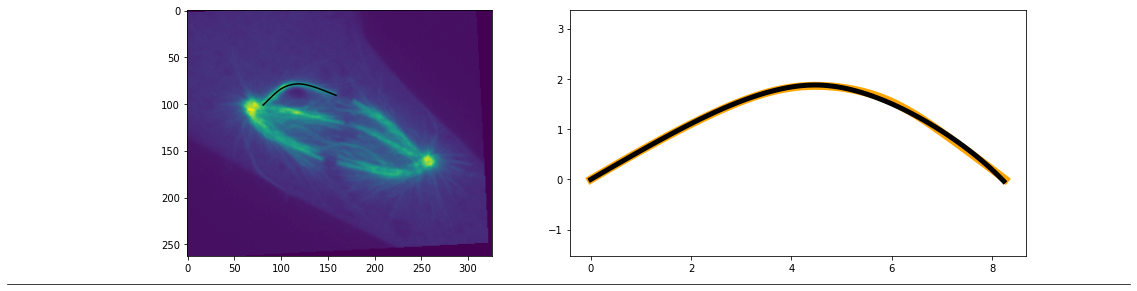

0 timestrip_02


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 180000/180000 [13:27<00:00, 222.99it/s]


RMSE: 0.0109
Max gap: 0.0223

 F, xF, xC, FC
[1.4, 4.342, 1.543, 0.375]

 Fx, Mk, Fy, theta0
[-0.487, 0.0, -0.304, 0.634]


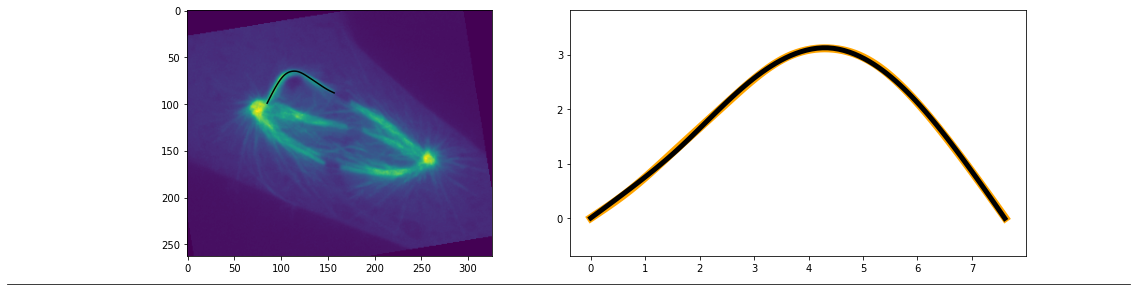

  0%|          | 0/5000 [00:00<?, ?it/s]

0 timestrip_03


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 180000/180000 [14:13<00:00, 210.80it/s]


RMSE: 0.0248
Max gap: 0.0573

 F, xF, xC, FC
[0.513, 4.724, 1.966, 0.254]

 Fx, Mk, Fy, theta0
[-0.053, 0.0, -0.023, 0.706]


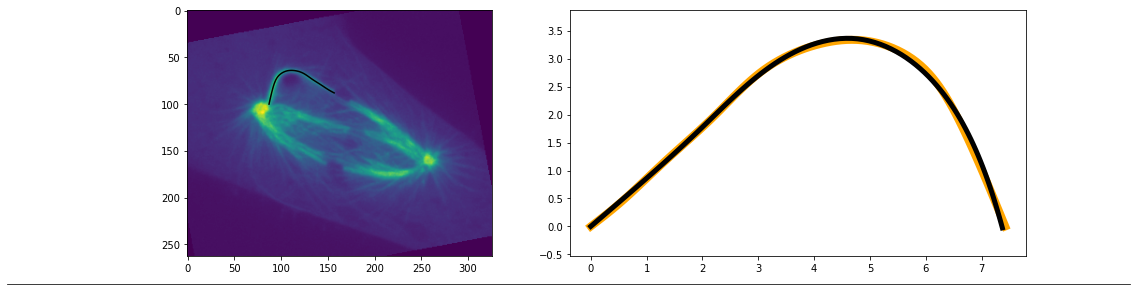

  0%|          | 0/5000 [00:00<?, ?it/s]

0 timestrip_04


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 180000/180000 [12:33<00:00, 238.87it/s]


RMSE: 0.0335
Max gap: 0.0689

 F, xF, xC, FC
[0.987, 5.532, 3.682, 0.517]

 Fx, Mk, Fy, theta0
[-0.07, 0.0, -0.037, 0.61]


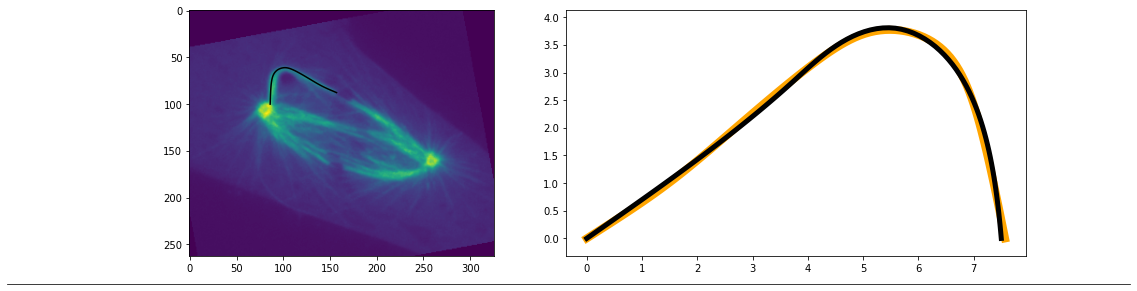

  0%|          | 0/5000 [00:00<?, ?it/s]

0 timestrip_05


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 180000/180000 [12:32<00:00, 239.11it/s]


RMSE: 0.0492
Max gap: 0.0792

 F, xF, xC, FC
[1.272, 5.506, 3.445, 0.551]

 Fx, Mk, Fy, theta0
[-0.169, 0.0, -0.119, 0.669]


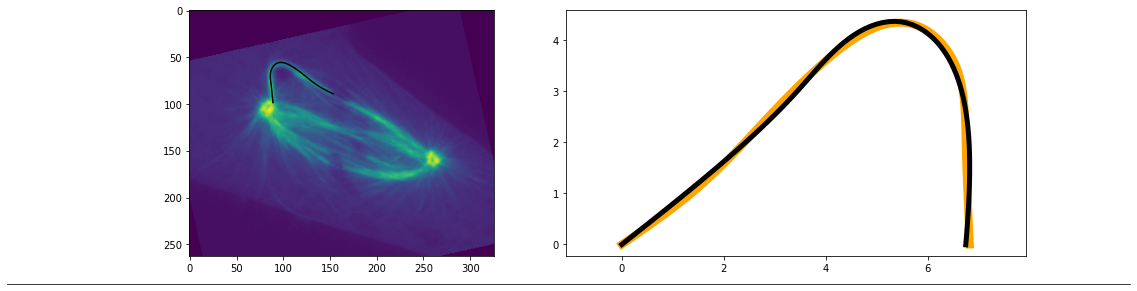

  0%|          | 0/5000 [00:00<?, ?it/s]

0 timestrip_06


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 180000/180000 [13:29<00:00, 222.31it/s]


RMSE: 0.0470
Max gap: 0.0914

 F, xF, xC, FC
[0.74, 5.555, 3.08, 0.45]

 Fx, Mk, Fy, theta0
[-0.005, 0.0, 0.04, 0.568]


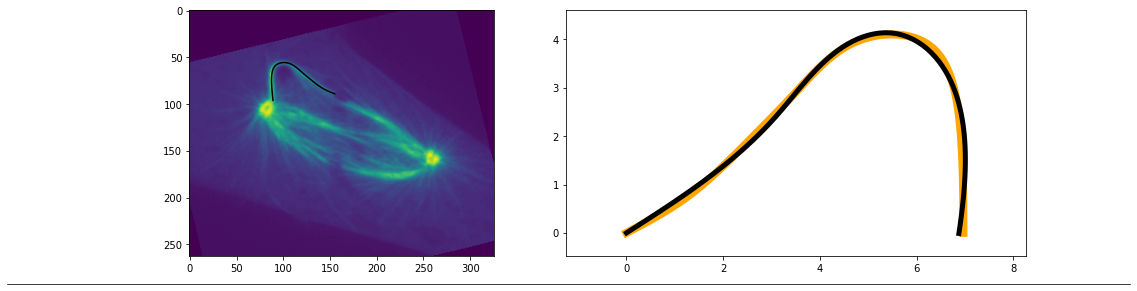

  0%|          | 0/5000 [00:00<?, ?it/s]

0 timestrip_07


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 180000/180000 [15:27<00:00, 194.12it/s]


RMSE: 0.0265
Max gap: 0.0546

 F, xF, xC, FC
[1.04, 5.837, 3.841, 0.537]

 Fx, Mk, Fy, theta0
[-0.063, 0.0, -0.028, 0.617]


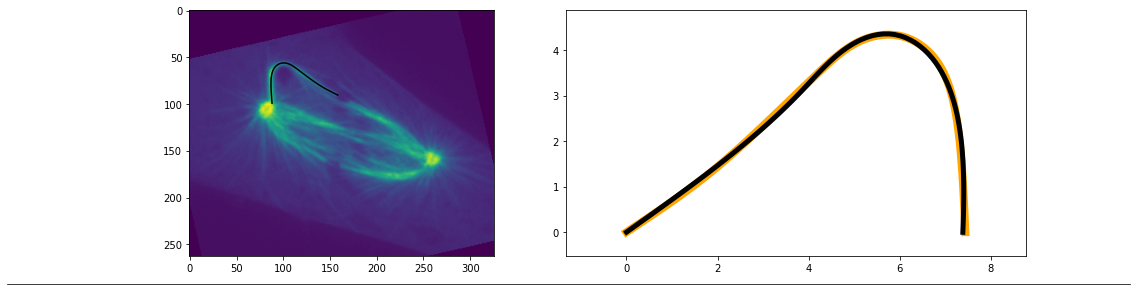

  0%|          | 0/5000 [00:00<?, ?it/s]

0 timestrip_08


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 180000/180000 [14:59<00:00, 200.20it/s]


RMSE: 0.0346
Max gap: 0.0739

 F, xF, xC, FC
[0.961, 5.782, 3.955, 0.562]

 Fx, Mk, Fy, theta0
[-0.0, 0.0, 0.017, 0.634]


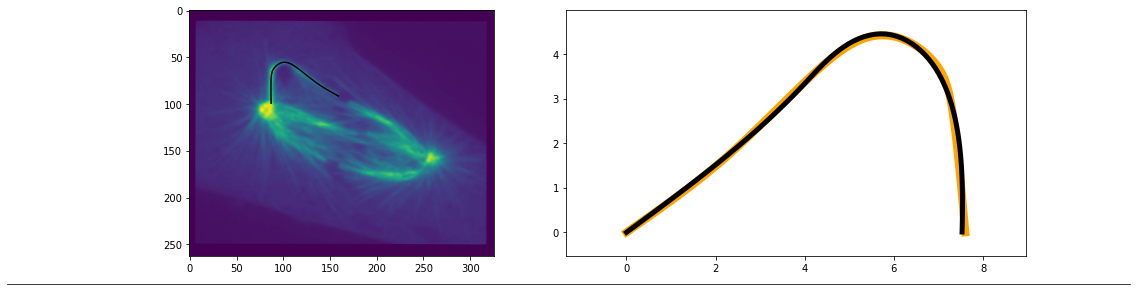

  0%|          | 0/5000 [00:00<?, ?it/s]

0 timestrip_09


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 180000/180000 [15:41<00:00, 191.26it/s]


RMSE: 0.0326
Max gap: 0.0833

 F, xF, xC, FC
[0.915, 5.889, 4.029, 0.555]

 Fx, Mk, Fy, theta0
[-0.016, 0.0, 0.009, 0.591]


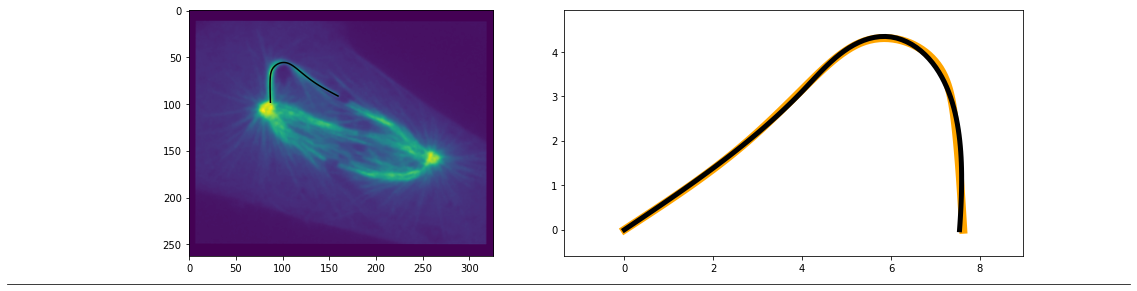

  0%|          | 0/5000 [00:00<?, ?it/s]

0 timestrip_10


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 180000/180000 [16:47<00:00, 178.61it/s]


RMSE: 0.0297
Max gap: 0.0639

 F, xF, xC, FC
[0.902, 6.065, 4.267, 0.535]

 Fx, Mk, Fy, theta0
[-0.004, 0.0, 0.008, 0.621]


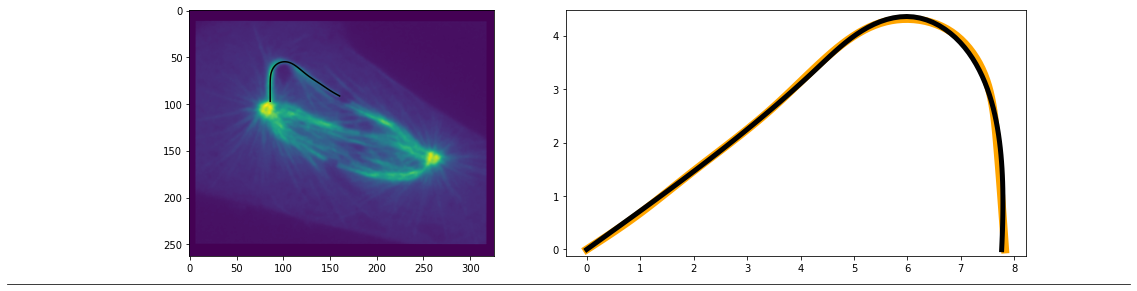

  0%|          | 0/5000 [00:00<?, ?it/s]

0 timestrip_11


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 180000/180000 [15:23<00:00, 194.87it/s]


RMSE: 0.0529
Max gap: 0.1183

 F, xF, xC, FC
[0.71, 6.042, 4.096, 0.443]

 Fx, Mk, Fy, theta0
[-0.007, 0.0, 0.004, 0.653]


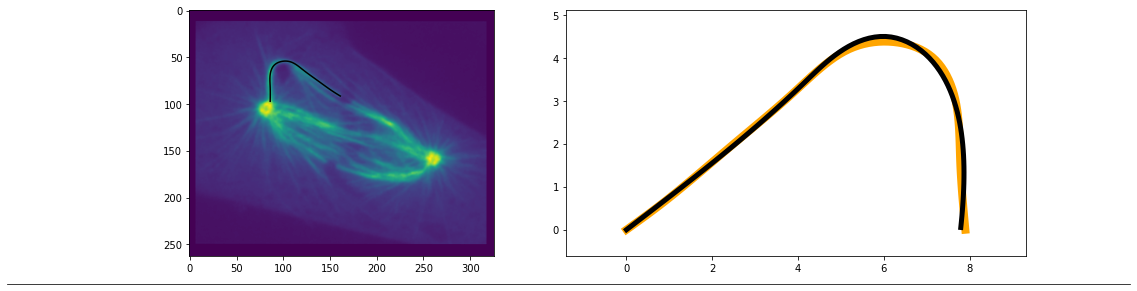

0 timestrip_12


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 180000/180000 [12:24<00:00, 241.91it/s]


RMSE: 0.0632
Max gap: 0.1519

 F, xF, xC, FC
[0.705, 6.112, 4.352, 0.453]

 Fx, Mk, Fy, theta0
[-0.002, 0.0, 0.004, 0.653]


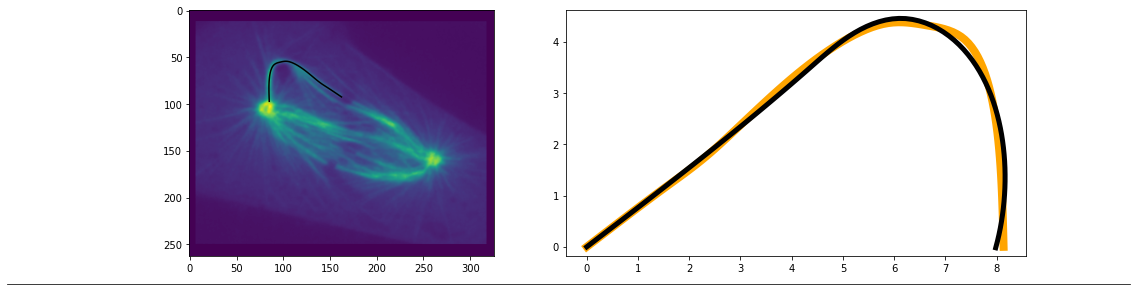

  0%|          | 0/5000 [00:00<?, ?it/s]

0 timestrip_13


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 180000/180000 [13:43<00:00, 218.69it/s]


RMSE: 0.0564
Max gap: 0.1475

 F, xF, xC, FC
[1.105, 6.806, 5.535, 0.727]

 Fx, Mk, Fy, theta0
[-0.015, 0.0, -0.013, 0.64]


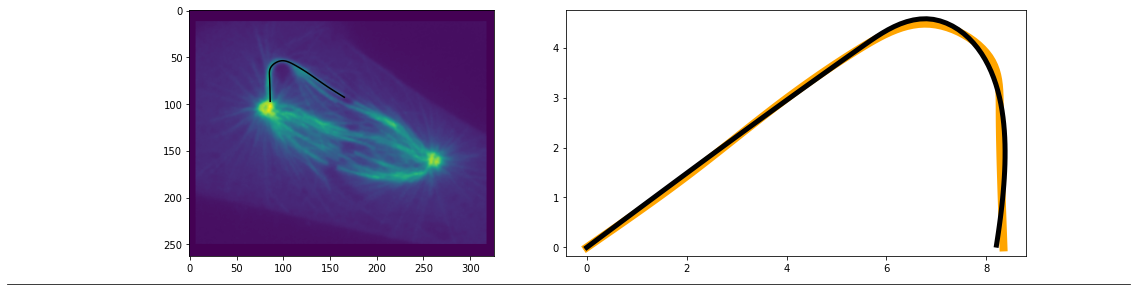

../../dat/Dynamics/timestrip_05.csv
../../dat/Dynamics/timestrip_06.csv
../../dat/Dynamics/timestrip_07.csv
../../dat/Dynamics/timestrip_08.csv
../../dat/Dynamics/timestrip_09 copy.csv
../../dat/Dynamics/timestrip_09.csv
../../dat/Dynamics/timestrip_10 2.csv
../../dat/Dynamics/timestrip_10.csv
../../dat/Dynamics/timestrip__03.csv
../../dat/Dynamics/timestrip__06_.csv


In [199]:
df_fin_point_force = pd.DataFrame()
    

sigma_xF = 0.05 #less wiggle room 
path = "../../dat/Dynamics/"
cells = sorted(glob.glob("%s/*"%path))
cells = [cell for cell in cells if not 'Icon' in cell]
cells = [cell for cell in cells if not '20180926_cell007_workswell' in cell]
cells = [cell for cell in cells if not '20180926_cell007' in cell]

n_dim = 8
n_keep = 2*n_dim
n_steps_explore = 5000
n_steps_full = 180000
cols = ['Fx', 'Mk', 'Fy', 'theta0', 'F', 'xF', 'xC', 'FC']


for n, cell in enumerate(cells):
    print(cell)
    times = sorted(glob.glob("%s/*csv"%(cell)))
    times = [time for time in times if not 'Icon' in time]
    for m,time in enumerate(times):
        spindle = time.split("/")[-1].split(".")[0]
        if m==0:
            continue
#         if m not in [10]:
#             continue
        np.random.seed(1)
        
        image = mpimg.imread("%s/%s.tif"%(cell,spindle))
        profile = glob.glob("%s/%s.csv"%(cell,spindle))[0]

        df_dat = pd.read_csv(profile)

        x_dat = df_dat["X"].values
        y_dat = df_dat["Y"].values

        print(n,spindle)
        fig, ax = plt.subplots(1, 2, figsize = (13, 4))

        ax[0].imshow(image)
        ax[0].plot(x_dat, y_dat, color = 'k')

        angle = np.arctan((y_dat[-1] - y_dat[0]) / (x_dat[-1] - x_dat[0]))
        x_dat,y_dat = rotate(x_dat,y_dat,angle)

        # Translation to start at origin
        x_dat -= x_dat[0]
        y_dat -= y_dat[0]

        # Flipping to ensure a positive initial slope
        theta0 = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])
        if theta0 < 0.0:
            y_dat = -y_dat
            angle = -angle

        # Convert from pixel to micron units based on scope camera calibration
        is_2017 = re.search('2017',cell.split("/")[-1])
        is_2021 = re.search('2021',cell.split("/")[-1])
        if is_2017:
            scope_calibration = 1/0.0657
        elif is_2021:
            scope_calibration = 1/0.0657
        else:
            scope_calibration = 1/0.105

        x_dat = x_dat/scope_calibration
        y_dat = y_dat/scope_calibration

        # P-K distance
        L = x_dat[-1] - x_dat[0]

        # Flip the profile
        y_dat = np.flip(y_dat)
        x_dat = L - np.flip(x_dat)

        # Initial angle
        theta0 = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])

        y_needle = np.max(y_dat)
        x_needle = x_dat[np.where(y_dat == np.max(y_dat))]

        x_peak = x_needle[0]
        theta_peak = np.arctan(y_dat[y_dat==y_dat.max()]/x_dat[y_dat==y_dat.max()])[0]



        # ----------------- Parameter inference: MCMC ----------------- #
        Mk_zero = True

        window = 10
        C_dat = curvature(x_dat, y_dat,window)
#         print(C_dat)
        if np.min(C_dat) < 0.0:
            FC_zero = False
        else:
            print("FC_zero")
            FC_zero = True
            
        Mk_init = 0.0
        theta0_init = theta_peak
        xF_init = x_peak
        xC_init = 1.0
        FC_init = 0.01

        end_to_end = np.inf
        args = (x_dat, y_dat, x_peak, sigma_xF, Mk_zero, FC_zero, end_to_end)

        p_init_set = []
        for Fext_init in np.logspace(-1, 0.5, 5):
            for Fx_init in -np.linspace(0, 1, 4)*Fext_init:
                for Fy_init in -np.linspace(0, 0.5, 4)*Fext_init:
                    for xC_init in [1.0, 2.0]:
                        for FC_init in [0.01, 0.05]:

                            p_init = np.array([Fx_init, Mk_init, Fy_init, theta0_init, Fext_init, xF_init, \
                                               xC_init, FC_init])

                            if logpost_exact(p_init, *args) != -np.inf:
                                p_init_set.append(p_init)

        if len(p_init_set) < 2*n_dim:
            for i in range(2*n_dim-len(p_init_set)):
                p_init_set.append(p_init_set[i])

        eps = 1e-2*np.random.rand(len(p_init_set), n_dim)
        p_init_set = np.array(p_init_set) + eps

        n_walkers = len(p_init_set)
        sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, args=args, threads=3)
        _ = sampler.run_mcmc(p_init_set, n_steps_explore, progress=True)
        df_mcmc = sampler_to_dataframe(sampler, columns=cols)



        args = (x_dat, y_dat, x_peak, sigma_xF, Mk_zero, FC_zero, end_to_end)

        p_init_subset = give_top_chain(df_mcmc, n_dim, n_keep)
        n_walkers = len(p_init_subset)
        sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, args=args, threads=3)
        _ = sampler.run_mcmc(p_init_subset, n_steps_full, progress=True)
        df_mcmc = sampler_to_dataframe(sampler, columns=cols)


        p_opt_mcmc = df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()].values[0][:-2]
        deflect_arrays, deflect_numbers = deflection_exact_FC(p_opt_mcmc, x_dat, y_dat, Mk_zero, FC_zero)
        x_mod_mcmc = deflect_arrays["x_mod"]
        y_mod_mcmc = deflect_arrays["y_mod"]
        M_mod_mcmc = deflect_arrays["M_mod"]
        xF = deflect_numbers['xF']
        yF = deflect_numbers['yF']
        thetaF = deflect_numbers['thetaF']

        _, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod_mcmc, y_mod_mcmc)
        ind_pairs = ind_pairs.astype('int')
        x_mod_mcmc_truncated = x_mod_mcmc[:ind_pairs[-1]+1]
        y_mod_mcmc_truncated = y_mod_mcmc[:ind_pairs[-1]+1]
        M_mod_mcmc_truncated = M_mod_mcmc[:ind_pairs[-1]+1]

#         print('Fx, Mk, Fy, theta0, F, xF, xC, FC')
#         print([np.round(x,3) for x in p_opt_mcmc])


        ax[1].plot(x_dat, y_dat, color="orange", lw = 8)
        ax[1].plot(x_mod_mcmc_truncated, y_mod_mcmc_truncated, color='k', lw = 5)
        ax[1].axis('equal')


        res = distances_pair_min_new(x_dat, y_dat, x_mod_mcmc_truncated, y_mod_mcmc_truncated)
        RMSE = np.sqrt(np.mean(res**2))
        gap_max = np.max(res)

        if show_details:
            print("RMSE: %.4f"%RMSE)
            print("Max gap: %.4f"%gap_max)

        Fx, Mk, Fy, theta0, Fext, xF, xC, FC = p_opt_mcmc
        
        if Mk_zero:
            Mk = 0.0
        if FC_zero:
            FC = 0.0
        print('\n F, xF, xC, FC')
        print([np.round(x,3) for x in [Fext, xF, xC, FC]])
        print('\n Fx, Mk, Fy, theta0')
        print([np.round(x,3) for x in [Fx, Mk, Fy, theta0]])

        plt.tight_layout()
        line = plt.Line2D([-0.1,1.1], [0,0], transform=fig.transFigure, color="black", lw = 0.75)
        fig.add_artist(line)
        plt.show()

        df_fin_point_force = df_fin_point_force.append({'Spindle': cell.split("/")[-1],
                                                        'time-point': spindle.split("_")[-1], 
                                                        'x_dat': x_dat,
                                                        'y_dat': y_dat,
                                                        'L': L,
                                                        'x': x_mod_mcmc_truncated,
                                                        'y': y_mod_mcmc_truncated,
                                                        'M': M_mod_mcmc_truncated,

                                                        'Fx': Fx,
                                                        'Mk': Mk,
                                                        'Fy': Fy,
                                                        'theta0': theta0,
                                                        'Fext': Fext,
                                                        'thetaF': thetaF,
                                                        'xF': xF,
                                                        'yF': yF,
                                                        'xC': xC,
                                                        'FC': FC,

                                                        'gap_max': gap_max, 
                                                        'RMSE': RMSE}, ignore_index=True)

In [200]:
if save_results:
    f = open('effective_point_force_dynamics_ex.pkl', 'wb')
    pickle.dump(df_fin_point_force, f)
    f.close()

In [ ]:
# if save_results:
#     f = open('case19.pkl', 'wb')
#     pickle.dump(df_fin_point_force, f)
#     f.close()